In [5]:
%pip install pandas numpy matplotlib seaborn scikit-learn xgboost

Note: you may need to restart the kernel to use updated packages.



CONCEPT DRIFT ANALYSIS: TEMPORAL BUCKETS

Dataset split:
  All data:          5124 posts
  Until 2025-03-31:  4125 posts
  From 2025-04-01:   999 posts

BUCKET: All data
Total rows: 5124
Train: 4099 | Test: 1025
Class distribution: {0: 0.5, 1: 0.5}
Class ratio (0:1): 1.00

Training XGBoost with Regularization-Focused Hyperparameter Tuning...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Hyperparameters for All data:
  subsample: 0.5
  scale_pos_weight: 1
  reg_lambda: 20
  reg_alpha: 1.0
  n_estimators: 700
  min_child_weight: 10
  max_depth: 4
  learning_rate: 0.03
  gamma: 1.0
  colsample_bytree: 0.7
  colsample_bylevel: 0.5

Cross-Validation Performance:
  Training Accuracy:   0.7230
  Validation Accuracy: 0.6577
  Overfitting Gap:     0.0653
  ✓ Overfitting well controlled!

Test Set Performance:
  Accuracy:  0.6693
  ROC-AUC:   0.7359
  F1-Score:  0.6744
  Val-Test Gap: -0.0115
  ✓ Excellent generalization to test set!

Classification Report:
              

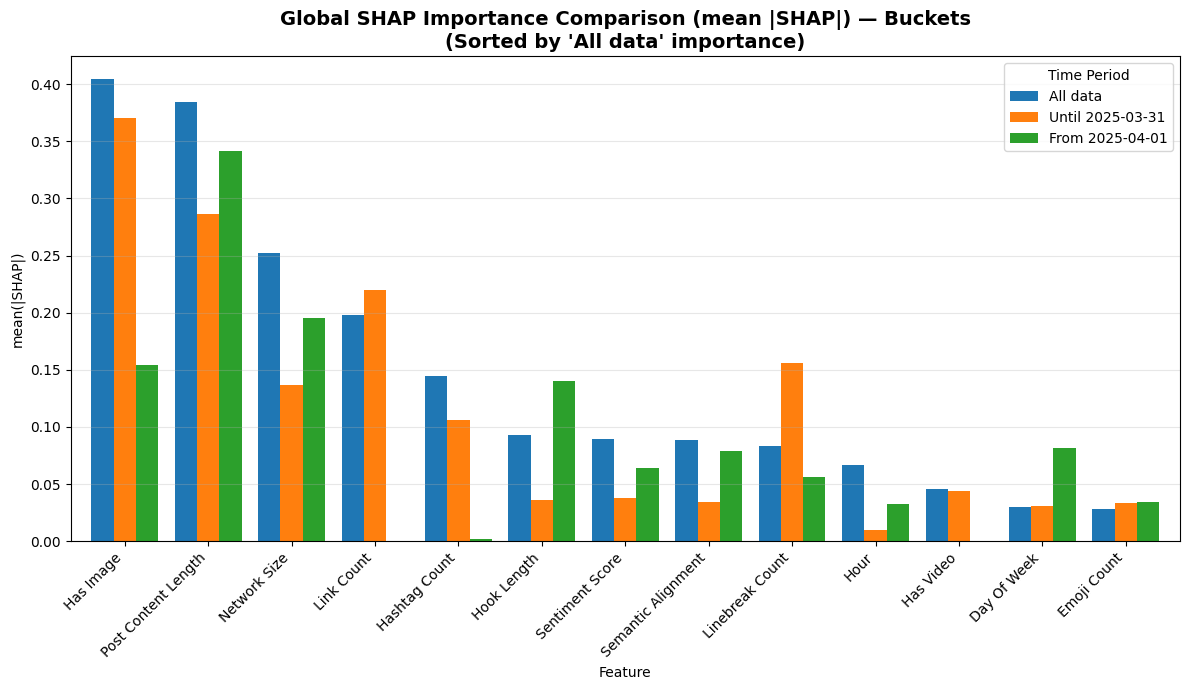


MODEL PERFORMANCE SUMMARY ACROSS TIME PERIODS
                  train_acc  val_acc  test_acc  test_auc  test_f1  \
All data             0.7230   0.6577    0.6693    0.7359   0.6744   
Until 2025-03-31     0.6903   0.6627    0.6885    0.7512   0.6937   
From 2025-04-01      0.6577   0.6295    0.6150    0.6569   0.6169   

                  overfitting_gap  val_test_gap  
All data                   0.0653       -0.0115  
Until 2025-03-31           0.0276       -0.0258  
From 2025-04-01            0.0282        0.0145  

CONCEPT DRIFT: FEATURE IMPORTANCE SHIFTS

Feature Importance Changes (sorted by 'All data' baseline):
                     All Data  Pre-March  Post-March  Δ (Absolute)       Δ (%)
Has Image              0.4041     0.3700      0.1545       -0.2155  -58.245300
Post Content Length    0.3842     0.2862      0.3410        0.0548   19.165199
Network Size           0.2526     0.1364      0.1950        0.0586   42.957298
Link Count             0.1980     0.2201      0.0000     

In [10]:
# Concept Drift Analysis: Compare algorithm performance across time periods

# Load the dataset
df_ml = pd.read_csv(INPUT_FILE)

# Parse datetime
df_ml[DATE_COL] = pd.to_datetime(df_ml["Post Timestamp DT"], errors="coerce")

def run_bucket(df_bucket, label):
    """Train and evaluate XGBoost model on a temporal bucket of data"""
    
    # Build X/y
    X = df_bucket[features].copy()
    y = df_bucket["Is High Performing"].copy()
    
    # Check class balance
    class_ratio = y.value_counts()[0] / y.value_counts()[1] if len(y.value_counts()) > 1 else 1.0
    
    # Train/Test Split with stratification
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"\n{'='*60}")
    print(f"BUCKET: {label}")
    print(f"{'='*60}")
    print(f"Total rows: {len(df_bucket)}")
    print(f"Train: {len(X_train)} | Test: {len(X_test)}")
    print(f"Class distribution: {y.value_counts(normalize=True).to_dict()}")
    print(f"Class ratio (0:1): {class_ratio:.2f}")

    # Even more aggressive regularization to close the gap
    param_grid = {
        # Even simpler trees
        "max_depth": [2, 3, 4],  # Focus on shallower trees
        "min_child_weight": [10, 15, 20, 25],  # Higher minimum samples
        
        # Slower learning
        "learning_rate": [0.01, 0.02, 0.03],
        "n_estimators": [200, 300, 500, 700],
        
        # Stronger regularization
        "reg_alpha": [1.0, 2.0, 5.0, 10.0],  # Stronger L1
        "reg_lambda": [5, 10, 15, 20],  # Stronger L2
        
        # More aggressive sampling
        "subsample": [0.5, 0.6, 0.7],
        "colsample_bytree": [0.5, 0.6, 0.7],
        "colsample_bylevel": [0.5, 0.6, 0.7],
        
        # Higher split cost
        "gamma": [1.0, 2.0, 3.0, 5.0],
        
        # Handle class imbalance
        "scale_pos_weight": [1, class_ratio, class_ratio * 1.5],
    }

    print("\nTraining XGBoost with Regularization-Focused Hyperparameter Tuning...")
    
    # Use StratifiedKFold
    from sklearn.model_selection import StratifiedKFold
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    search = RandomizedSearchCV(
        XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            random_state=42,
            n_jobs=-1
        ),
        param_distributions=param_grid,
        n_iter=100,  # More iterations for better search
        cv=cv_strategy,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1,
        random_state=42,
        return_train_score=True
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    
    # Check train/val gap from CV
    cv_results = pd.DataFrame(search.cv_results_)
    best_idx = search.best_index_
    train_score = cv_results.loc[best_idx, 'mean_train_score']
    val_score = cv_results.loc[best_idx, 'mean_test_score']
    overfitting_gap = train_score - val_score
    
    print(f"\n{'='*60}")
    print(f"Best Hyperparameters for {label}:")
    print(f"{'='*60}")
    for param, value in search.best_params_.items():
        print(f"  {param}: {value}")
    
    print(f"\nCross-Validation Performance:")
    print(f"  Training Accuracy:   {train_score:.4f}")
    print(f"  Validation Accuracy: {val_score:.4f}")
    print(f"  Overfitting Gap:     {overfitting_gap:.4f}")
    
    # Assess overfitting level
    if overfitting_gap < 0.08:
        print(f"  ✓ Overfitting well controlled!")
    elif overfitting_gap < 0.15:
        print(f"  ⚠ Mild overfitting - acceptable for this domain")
    else:
        print(f"  ✗ Significant overfitting - consider more regularization")

    # Evaluation on test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    test_acc = accuracy_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_prob)
    test_f1 = f1_score(y_test, y_pred)
    
    # Check val-test alignment
    val_test_gap = val_score - test_acc

    print(f"\nTest Set Performance:")
    print(f"  Accuracy:  {test_acc:.4f}")
    print(f"  ROC-AUC:   {test_auc:.4f}")
    print(f"  F1-Score:  {test_f1:.4f}")
    print(f"  Val-Test Gap: {val_test_gap:.4f}")
    
    if abs(val_test_gap) < 0.02:
        print(f"  ✓ Excellent generalization to test set!")
    elif abs(val_test_gap) < 0.05:
        print(f"  ✓ Good generalization to test set")
    else:
        print(f"  ⚠ Val-test gap larger than expected")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{'='*60}\n")

    # SHAP Analysis
    print(f"Computing SHAP values for {label}...")
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)

    # Handle different SHAP output formats
    if isinstance(shap_values, list):
        shap_to_plot = shap_values[1]
    else:
        shap_values = np.asarray(shap_values)
        if shap_values.ndim == 3:
            shap_to_plot = shap_values[:, :, 1]
        else:
            shap_to_plot = shap_values

    # Calculate mean absolute SHAP values (global importance)
    mean_abs_shap = np.abs(shap_to_plot).mean(axis=0)
    shap_imp = pd.Series(mean_abs_shap, index=X_test.columns).sort_values(ascending=False)
    
    # Extract built-in feature importance
    feature_imp = pd.Series(
        best_model.feature_importances_, 
        index=X_test.columns
    ).sort_values(ascending=False)
    
    print(f"SHAP analysis complete for {label}")
    print(f"Top 5 features by SHAP:")
    for i, (feat, val) in enumerate(shap_imp.head(5).items(), 1):
        print(f"  {i}. {feat}: {val:.4f}")

    return shap_imp, feature_imp, best_model, {
        'train_acc': train_score,
        'val_acc': val_score,
        'test_acc': test_acc,
        'test_auc': test_auc,
        'test_f1': test_f1,
        'overfitting_gap': overfitting_gap,
        'val_test_gap': val_test_gap
    }


# ============================================================
# DEFINE TEMPORAL BUCKETS
# ============================================================

print("\n" + "="*60)
print("CONCEPT DRIFT ANALYSIS: TEMPORAL BUCKETS")
print("="*60)

bucket_all = df_ml.dropna(subset=[DATE_COL]).copy()
bucket_before_march = df_ml[df_ml[DATE_COL] < pd.Timestamp("2025-04-01")].copy()
bucket_march = df_ml[df_ml[DATE_COL] >= pd.Timestamp("2025-04-01")].copy()

print(f"\nDataset split:")
print(f"  All data:          {len(bucket_all)} posts")
print(f"  Until 2025-03-31:  {len(bucket_before_march)} posts")
print(f"  From 2025-04-01:   {len(bucket_march)} posts")

# Store results
results_shap = []
results_feature = []
models = {}
performance_metrics = {}

# ============================================================
# RUN ANALYSIS FOR EACH BUCKET
# ============================================================

# Bucket 1: All data (RUN THIS FIRST - used for sorting!)
shap_all, feat_all, model_all, metrics_all = run_bucket(bucket_all, "All data")
results_shap.append(("All data", shap_all))
results_feature.append(("All data", feat_all))
models["All data"] = model_all
performance_metrics["All data"] = metrics_all

# Bucket 2: Before March 2025
shap_before, feat_before, model_before, metrics_before = run_bucket(
    bucket_before_march, "Until 2025-03-31"
)
results_shap.append(("Until 2025-03-31", shap_before))
results_feature.append(("Until 2025-03-31", feat_before))
models["Until 2025-03-31"] = model_before
performance_metrics["Until 2025-03-31"] = metrics_before

# Bucket 3: From March 2025
shap_march, feat_march, model_march, metrics_march = run_bucket(
    bucket_march, "From 2025-04-01"
)
results_shap.append(("From 2025-04-01", shap_march))
results_feature.append(("From 2025-04-01", feat_march))
models["From 2025-04-01"] = model_march
performance_metrics["From 2025-04-01"] = metrics_march

# ============================================================
# BUILD COMPARISON DATAFRAMES
# ============================================================

# Build (features x buckets) dataframe for SHAP
shap_df = pd.concat([s.rename(name) for name, s in results_shap], axis=1).fillna(0)

# Build (features x buckets) dataframe for Feature Importance
feature_df = pd.concat([s.rename(name) for name, s in results_feature], axis=1).fillna(0)

# ============================================================
# VISUALIZE SHAP COMPARISON - SORTED BY "ALL DATA"
# ============================================================

print("\n" + "="*60)
print("SHAP IMPORTANCE COMPARISON ACROSS TIME PERIODS")
print("="*60)

# ✅ KEY CHANGE: Sort by "All data" column instead of average
if "All data" in shap_df.columns:
    # Get feature order from "All data" bucket (descending)
    feature_order = shap_df["All data"].sort_values(ascending=False).index
    
    # Reorder dataframe to match this order
    shap_sorted = shap_df.loc[feature_order]
    
    print(f"\nFeature ordering based on 'All data' SHAP importance:")
    for i, feat in enumerate(feature_order, 1):
        print(f"  {i:2d}. {feat:25s} (SHAP: {shap_df.loc[feat, 'All data']:.4f})")
else:
    print("Warning: 'All data' column not found, using average-based sorting")
    feature_order = shap_df.mean(axis=1).sort_values(ascending=False).index
    shap_sorted = shap_df.loc[feature_order]

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 7))
shap_sorted.plot(kind="bar", ax=ax, width=0.8)
ax.set_title("Global SHAP Importance Comparison (mean |SHAP|) — Buckets\n(Sorted by 'All data' importance)", 
             fontsize=14, fontweight='bold')
ax.set_ylabel("mean(|SHAP|)")
ax.set_xlabel("Feature")
ax.legend(title="Time Period", loc='upper right')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# PERFORMANCE METRICS SUMMARY
# ============================================================

print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY ACROSS TIME PERIODS")
print("="*60)

metrics_df = pd.DataFrame(performance_metrics).T
print(metrics_df.round(4))

# ============================================================
# CONCEPT DRIFT ANALYSIS - ALSO SORTED BY "ALL DATA"
# ============================================================

print("\n" + "="*60)
print("CONCEPT DRIFT: FEATURE IMPORTANCE SHIFTS")
print("="*60)

# Calculate delta between time periods
if "Until 2025-03-31" in shap_df.columns and "From 2025-04-01" in shap_df.columns:
    drift_analysis = pd.DataFrame({
        'All Data': shap_df["All data"],
        'Pre-March': shap_df["Until 2025-03-31"],
        'Post-March': shap_df["From 2025-04-01"],
        'Δ (Absolute)': shap_df["From 2025-04-01"] - shap_df["Until 2025-03-31"],
        'Δ (%)': (
            (shap_df["From 2025-04-01"] - shap_df["Until 2025-03-31"]) / 
            (shap_df["Until 2025-03-31"] + 1e-10) * 100
        )
    })
    
    # ✅ Sort by "All data" importance (descending) for consistency
    drift_analysis = drift_analysis.loc[feature_order]
    
    print("\nFeature Importance Changes (sorted by 'All data' baseline):")
    print(drift_analysis.round(4))
    
    # Identify trends
    print("\n" + "-"*60)
    print("Top 5 Features with INCREASED Importance (Post-March vs Pre-March):")
    print("-"*60)
    increased = drift_analysis.sort_values('Δ (Absolute)', ascending=False).head(5)
    for feat in increased.index:
        row = increased.loc[feat]
        print(f"  {feat:25s}: {row['Pre-March']:6.4f} → {row['Post-March']:6.4f}  "
              f"(Δ {row['Δ (Absolute)']:+.4f}, {row['Δ (%)']:+6.1f}%)")
    
    print("\n" + "-"*60)
    print("Top 5 Features with DECREASED Importance (Post-March vs Pre-March):")
    print("-"*60)
    decreased = drift_analysis.sort_values('Δ (Absolute)', ascending=True).head(5)
    for feat in decreased.index:
        row = decreased.loc[feat]
        print(f"  {feat:25s}: {row['Pre-March']:6.4f} → {row['Post-March']:6.4f}  "
              f"(Δ {row['Δ (Absolute)']:+.4f}, {row['Δ (%)']:+6.1f}%)")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)